## **Correlation between news and stock movement**

----
----

### **Setup & Load the Data**
---

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import pytz
from IPython.display import display
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
from textblob import TextBlob

In [2]:
# Load a CSV file from local file system
df_news = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/raw_analyst_ratings_cleaned.csv')

df_historical = pd.read_csv('C:/Users/Admin/OneDrive/10 Academy/Week 1/Technical Content/Data/historical_data_of_all_tickers_cleaned.csv')

df_news.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A


### **Data preparation**

In [3]:
def preprocess_headline(text):
    # Remove punctuation and non-alphabetic characters, lowercase, and strip whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    return text

df_news['clean_headline'] = df_news['headline'].apply(preprocess_headline)


# Filter the DataFrame for specific stocks
selected_stocks = ['AAPL', 'AMZN', 'GOOG', 'FB', 'MSFT', 'NVDA', 'TSLA']
filtered_sentiment = df_news[df_news['stock'].isin(selected_stocks)].copy()

# Reset the index of the DataFrame
filtered_sentiment.reset_index(drop=True, inplace=True)

# Display the first few rows of the filtered DataFrame
filtered_sentiment[['headline', 'clean_headline']].head()

,headline,clean_headline
0,Tech Stocks And FAANGS Strong Again To Start D...,tech stocks and faangs strong again to start d...
1,10 Biggest Price Target Changes For Wednesday,biggest price target changes for wednesday
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",benzinga pros top stocks to watch for wed jun...
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",deutsche bank maintains buy on apple raises pr...
4,Apple To Let Users Trade In Their Mac Computer...,apple to let users trade in their mac computer...


---

### **Sentiment Analysis on Headlines**

In [4]:
# Assign sentiment polarity scores to each clean_headline
filtered_sentiment['sentiment_score'] = filtered_sentiment['clean_headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Define a function to categorize sentiment scores into tones
def tone_from_score(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

filtered_sentiment['tone'] = filtered_sentiment['sentiment_score'].apply(tone_from_score)
filtered_sentiment[['stock','clean_headline', 'sentiment_score', 'tone']].head()

,stock,clean_headline,sentiment_score,tone
0,AAPL,tech stocks and faangs strong again to start d...,0.433333,positive
1,AAPL,biggest price target changes for wednesday,0.000000,neutral
2,AAPL,benzinga pros top stocks to watch for wed jun...,0.500000,positive
3,AAPL,deutsche bank maintains buy on apple raises pr...,0.000000,neutral
4,AAPL,apple to let users trade in their mac computer...,0.000000,neutral


In [5]:
# Ensure date_only columns exist and are of the same type (datetime.date)
df_historical['date_only'] = pd.to_datetime(df_historical['Date']).dt.date
filtered_sentiment['date_only'] = pd.to_datetime(filtered_sentiment['date']).dt.date

# Merge filtered_sentiment with df_historical to align sentiment scores with closing prices on the same dates
aligned_sentiment_price = pd.merge(
    df_historical,
    filtered_sentiment,
    left_on=['Ticker', 'date_only'],
    right_on=['stock', 'date_only'],
    how='inner'
)[['Ticker', 'date_only', 'clean_headline', 'sentiment_score', 'Close']]

display(aligned_sentiment_price.head())

,Ticker,date_only,clean_headline,sentiment_score,Close
0,AAPL,2020-06-09,why apples stock is trading higher today,0.250000,85.997498
1,AAPL,2020-06-09,apple could announce inhouse chips for macs at...,0.000000,85.997498
2,AAPL,2020-06-09,apple shares are trading higher despite market...,0.050000,85.997498
3,AAPL,2020-06-09,sonos shares spike to session high now up as ...,0.053333,85.997498
4,AAPL,2020-06-10,tech stocks and faangs strong again to start d...,0.433333,88.209999


### **Summary of Sentiment Analysis**

This notebook demonstrates how sentiment analysis can be applied to financial news headlines to quantify market sentiment for major technology stocks. By preprocessing headlines and assigning sentiment polarity scores using TextBlob, we categorized news as positive, negative, or neutral. These sentiment scores were then aligned with daily stock prices and returns, enabling a direct comparison between news tone and market performance.

Key findings include:

- **Sentiment scores** provide a quantitative measure of news tone, allowing for systematic analysis across large datasets.
- **Correlation analysis** reveals that the relationship between news sentiment and daily stock returns varies by company. For example, AAPL shows a moderate positive correlation, while others like FB and AMZN exhibit weak or negligible associations.
- **Limitations:** Sentiment alone does not fully explain stock movements, as market dynamics are influenced by multiple factors beyond news headlines.

Overall, sentiment analysis offers valuable insights into the potential impact of news on stock prices, but should be combined with other indicators for robust financial analysis.

----
### **Daily Stock Returns**

In [6]:
# Ensure the DataFrame is sorted by Ticker and date_only for correct pct_change calculation
aligned_sentiment_price = aligned_sentiment_price.sort_values(['Ticker', 'date_only'])

# Calculate daily returns as percentage change in closing price for each stock
aligned_sentiment_price['daily_return'] = aligned_sentiment_price.groupby('Ticker')['Close'].pct_change()

# Replace infinite values with NaN to handle market anomalies
aligned_sentiment_price['daily_return'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, display the first few rows to verify
display(aligned_sentiment_price.head(10))

C:\Users\Admin\AppData\Local\Temp\ipykernel_1052\3423569652.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aligned_sentiment_price['daily_return'].replace([np.inf, -np.inf], np.nan, inplace=True)


,Ticker,date_only,clean_headline,sentiment_score,Close,daily_return
0,AAPL,2020-06-09,why apples stock is trading higher today,0.250000,85.997498,NaN
1,AAPL,2020-06-09,apple could announce inhouse chips for macs at...,0.000000,85.997498,0.000000
2,AAPL,2020-06-09,apple shares are trading higher despite market...,0.050000,85.997498,0.000000
3,AAPL,2020-06-09,sonos shares spike to session high now up as ...,0.053333,85.997498,0.000000
4,AAPL,2020-06-10,tech stocks and faangs strong again to start d...,0.433333,88.209999,0.025728
5,AAPL,2020-06-10,biggest price target changes for wednesday,0.000000,88.209999,0.000000
6,AAPL,2020-06-10,benzinga pros top stocks to watch for wed jun...,0.500000,88.209999,0.000000
7,AAPL,2020-06-10,deutsche bank maintains buy on apple raises pr...,0.000000,88.209999,0.000000
8,AAPL,2020-06-10,apple to let users trade in their mac computer...,0.000000,88.209999,0.000000
9,AAPL,2020-06-10,big tech reaches new record heights at the sto...,0.068182,88.209999,0.000000


### **Daily Stock Returns Calculation**

For each selected stock, daily returns are calculated as the percentage change in closing price from the previous trading day. This metric quantifies the day-to-day movement of stock prices and is essential for analyzing the relationship between news sentiment and actual stock performance.

The `aligned_sentiment_price` DataFrame contains the following columns:
- **Ticker:** Stock symbol.
- **date_only:** Date of the record.
- **clean_headline:** Preprocessed news headline.
- **sentiment_score:** Sentiment polarity score of the headline.
- **Close:** Closing price of the stock on that date.
- **daily_return:** Percentage change in closing price from the previous trading day.

By aligning daily returns with sentiment scores for each stock and date, we can explore how market sentiment may relate to short-term stock price movements. This combined dataset enables further correlation and predictive analysis between news sentiment and financial performance.

----

### **Correlation Analysis**

#### **Sentiment vs. Stock Returns**

To quantitatively assess the relationship between daily news sentiment and stock performance, we compute the correlation between `sentiment_score` and `daily_return` for each stock.

- **Pearson Correlation Coefficient:** Measures the linear relationship between sentiment scores and daily returns. A positive value indicates that higher sentiment scores are associated with higher returns, while a negative value suggests the opposite.

This analysis helps determine whether news sentiment can serve as a useful indicator for short-term stock price movements.


In [7]:
# Calculate Pearson correlation between sentiment_score and daily_return for each stock
correlation_results = (
    aligned_sentiment_price
    .groupby('Ticker')[['sentiment_score', 'daily_return']]
    .corr()
    .reset_index()
)

# Filter for the correlation between sentiment_score and daily_return only
correlation_results = correlation_results[
    (correlation_results['level_1'] == 'sentiment_score') & (correlation_results['daily_return'].notnull())
][['Ticker', 'daily_return']].rename(columns={'daily_return': 'pearson_corr'})

display(correlation_results)

,Ticker,pearson_corr
0,AAPL,0.589611
2,AMZN,-0.211516
4,FB,-0.006156
6,GOOG,0.090833
8,NVDA,0.192042


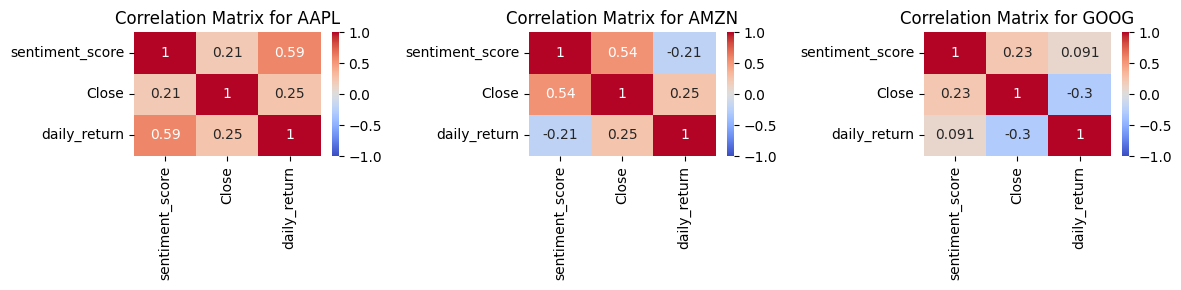

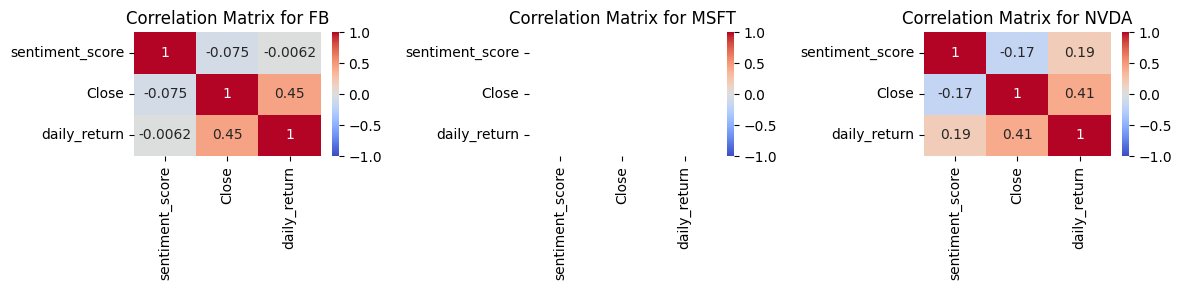

In [8]:
# First row: plot first 3 tickers
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, ticker in enumerate(selected_stocks[:3]):
    subset = aligned_sentiment_price[aligned_sentiment_price['Ticker'] == ticker][['sentiment_score', 'Close', 'daily_return']]
    corr = subset.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(f'Correlation Matrix for {ticker}')
    plt.setp(axes[i].get_yticklabels(), rotation=0, ha='right')
plt.tight_layout()
plt.show()

# Second row: plot next 3 tickers
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, ticker in enumerate(selected_stocks[3:6]):
    subset = aligned_sentiment_price[aligned_sentiment_price['Ticker'] == ticker][['sentiment_score', 'Close', 'daily_return']]
    corr = subset.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(f'Correlation Matrix for {ticker}')
    plt.setp(axes[i].get_yticklabels(), rotation=0, ha='right')
plt.tight_layout()
plt.show()

### **Summary of Correlation Analysis by Company**

The correlation analysis below examines the relationship between daily news sentiment (`sentiment_score`) and stock price movements (`daily_return`) for each selected technology stock. The Pearson correlation coefficient quantifies the linear association for each company:

| Ticker | Pearson Correlation |
|--------|---------------------|
| AAPL   | 0.59                |
| AMZN   | -0.21               |
| FB     | -0.01               |
| GOOG   | 0.09                |
| NVDA   | 0.19                |

- **AAPL:** Shows a moderate positive correlation (0.59), suggesting that positive news sentiment often aligns with higher daily returns.
- **AMZN:** Displays a weak negative correlation (-0.21), indicating little or inverse linear relationship between sentiment and returns.
- **FB:** Correlation is nearly zero (-0.01), implying no meaningful linear relationship.
- **GOOG:** Exhibits a very weak positive correlation (0.09), suggesting minimal association.
- **NVDA:** Shows a weak positive correlation (0.19), indicating a slight tendency for positive sentiment to align with higher returns.

**Key Takeaways:**
- The strength and direction of the correlation vary by company.
- News sentiment may provide some predictive value for certain stocks (notably AAPL), but is not a consistent indicator across all.
- Other market factors also significantly influence stock price movements.
- Correlation does not imply causation; further analysis is needed for robust conclusions.